#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05


### NOTE: THIS IS NEW MATERIAL, NOT YET IN THE TEXTBOOK

In [1]:
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    plot_partial_dependence,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

warnings.filterwarnings("ignore")


In [2]:
path = Path(os.getcwd())

base_dir = str(path.parent.parent)

data_in = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
data_out = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
output = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")

sys.path.append(func)
from py_helper_functions import *


## PART I
### Loading and preparing data 
----------------------------------------------

In [3]:
area = "london"
data = pd.read_csv(data_in + "airbnb_" + area + "_workfile_adj_book.csv")
data = data.loc[data.price.notna(), :]


In [4]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]


In [5]:
count_missing_values(data)


Series([], dtype: int64)

In [6]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.loc[lambda x: x["n_accommodates"] < 8]


In [7]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy=data.n_accommodates)


In [8]:
# basic descr stat -------------------------------------------
data.describe()


,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.00000,49826.000000,49826.000000,...,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,4.982600e+04,4.982600e+04,49826.000000,49826.000000
mean,88.984044,2.838759,1.224260,92.458616,12.340144,1.356180,1.138253,6.50873,3.300947,1.585959,...,0.318850,0.303998,0.303998,5.713297,33.456371,199.607207,2.931985e+05,3.046539e+08,4.520910,2.838759
std,70.515089,1.494748,0.466448,8.418474,25.889935,0.879263,1.238156,12.31549,29.578062,0.927501,...,0.466035,0.459986,0.459986,0.902564,9.506988,80.264045,5.640361e+05,9.636140e+08,0.120421,1.494748
min,8.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.010000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,41.000000,2.000000,1.000000,92.000000,0.000000,1.000000,0.470000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.000000,5.433722,29.525335,160.432461,5.198400e+04,1.185235e+07,4.521789,2.000000
50%,70.000000,2.000000,1.000000,94.000000,3.000000,1.000000,0.770000,0.00000,2.000000,1.000000,...,0.000000,0.000000,0.000000,5.793014,33.559007,194.407782,1.069290e+05,3.496578e+07,4.543295,2.000000
75%,110.000000,4.000000,1.000000,97.000000,12.000000,1.000000,1.170000,10.00000,3.000000,2.000000,...,1.000000,1.000000,1.000000,6.224558,38.745128,241.171311,2.540160e+05,1.280241e+08,4.574711,4.000000
max,999.000000,7.000000,8.000000,100.000000,396.000000,16.000000,15.000000,240.00000,5000.000000,16.000000,...,1.000000,1.000000,1.000000,7.909489,62.560024,494.817853,7.409284e+06,2.016807e+10,4.605170,7.000000


In [9]:
data.price.describe()


count    49826.000000
mean        88.984044
std         70.515089
min          8.000000
25%         41.000000
50%         70.000000
75%        110.000000
max        999.000000
Name: price, dtype: float64

In [10]:
data.f_room_type.value_counts()


Entire home/apt    24938
Private room       24351
Shared room          537
Name: f_room_type, dtype: int64

In [11]:
data.f_property_type.value_counts()


Apartment    37467
House        12359
Name: f_property_type, dtype: int64

In [12]:
data.f_number_of_reviews.value_counts()


2    31575
1    15148
3     3103
Name: f_number_of_reviews, dtype: int64

In [13]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines


In [14]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)


In [15]:
data_train.shape, data_holdout.shape


((34878, 93), (14948, 93))

In [16]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]


In [17]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2


## PART II
### RANDOM FORESTS 
-------------------------------------------------------

**Note:** n_estimators=500 in the R code.

Here, we set it to 30 because the model runs mutch faster, and this does not change the results substantively here – however in other cases might.

In [18]:
# NOTE: set number of cores you want to run models
ncores = 7


In [19]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [5, 7, 9], "min_samples_split": [6, 11]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=5, min_samples_split=6;, score=-45.973 total time=   1.8s
[CV 2/5] END max_features=5, min_samples_split=6;, score=-44.910 total time=   0.4s
[CV 3/5] END max_features=5, min_samples_split=6;, score=-45.928 total time=   0.4s
[CV 4/5] END max_features=5, min_samples_split=6;, score=-43.235 total time=   0.4s
[CV 5/5] END max_features=5, min_samples_split=6;, score=-46.685 total time=   0.4s
[CV 1/5] END max_features=5, min_samples_split=11;, score=-46.267 total time=   0.3s
[CV 2/5] END max_features=5, min_samples_split=11;, score=-45.263 total time=   0.3s
[CV 3/5] END max_features=5, min_samples_split=11;, score=-46.270 total time=   0.4s
[CV 4/5] END max_features=5, min_samples_split=11;, score=-43.829 total time=   0.4s
[CV 5/5] END max_features=5, min_samples_split=11;, score=-46.897 total time=   0.3s
[CV 1/5] END max_features=7, min_samples_split=6;, score=-45.547 total time=   0.4s
[CV 2/5] EN

In [20]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {
    "max_features": [8, 10, 12],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_split=6;, score=-45.167 total time=   0.4s
[CV 2/5] END max_features=8, min_samples_split=6;, score=-44.451 total time=   0.4s
[CV 3/5] END max_features=8, min_samples_split=6;, score=-45.206 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_split=6;, score=-42.702 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_split=6;, score=-45.734 total time=   0.4s
[CV 1/5] END max_features=8, min_samples_split=11;, score=-45.795 total time=   0.3s
[CV 2/5] END max_features=8, min_samples_split=11;, score=-44.615 total time=   0.3s
[CV 3/5] END max_features=8, min_samples_split=11;, score=-45.470 total time=   0.4s
[CV 4/5] END max_features=8, min_samples_split=11;, score=-42.869 total time=   0.4s
[CV 5/5] END max_features=8, min_samples_split=11;, score=-46.039 total time=   0.3s
[CV 1/5] END max_features=8, min_samples_split=16;, score=-45.641 total time=   0.4s
[CV 2/5] E

### Table 16.1 Random forest RMSE by tuning parameters

In [21]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)


Variables,8,10,12
Min_nodes,,,
5,44.65,44.46,44.24
10,44.96,44.74,44.37
15,44.98,44.74,44.52


In [22]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_1.best_estimator_.max_features,
            rf_model_2.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_1.best_estimator_.min_samples_split - 1,
            rf_model_2.best_estimator_.min_samples_split - 1,
        ],
    },
    ["Model A", "Model B"],
)


,Min vars,Min nodes
Model A,9,5
Model B,12,5


In [23]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B"],
).round(3) * -1


,RMSE
Model A,45.705
Model B,44.982


## PART III
### MODEL DIAGNOSTICS 
---

In [24]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        rf_model_2.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)


**1) full varimp plot, above a cutoff**

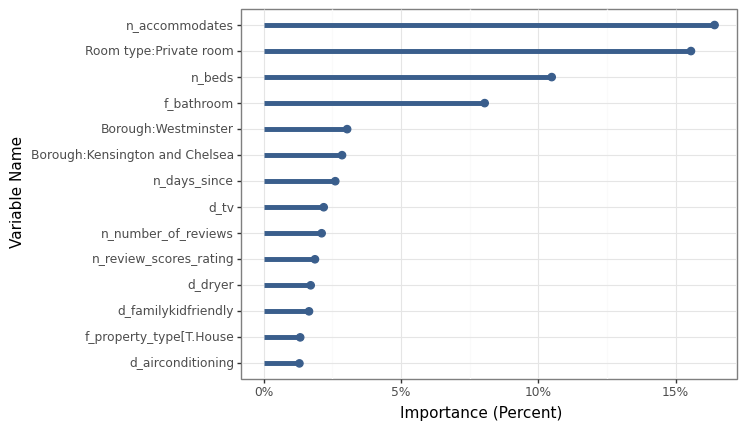

<ggplot: (388540398)>

In [25]:
cutoff = 0.013

rf_model_2_var_imp_plot = (
    ggplot(
        rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)
rf_model_2_var_imp_plot


**2) full varimp plot, top 10 only**

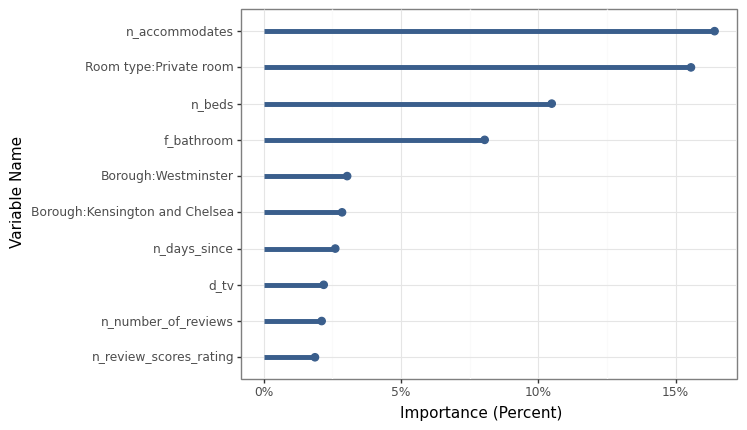

<ggplot: (393121232)>

In [26]:
(
    ggplot(
        rf_model_2_var_imp_df.iloc[:10, :],
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)


**3) grouped variable importance - keep binaries created off factors together**

For this, you need to create an sklearn pipeline and put OneHotEncoding in it (before, encoding was done by patsy's dmatrices). This way permutation_importance can calculate factor variables' importance 

In [27]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]


In [28]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),  # put best model to pipeline
    ]
)


In [29]:
rf_best_pipeline.fit(data_train[predictors_2], data_train.price)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
                                                   'd_doormanentry', 'd_dryer',
                                                   'd_elevatorinbuilding',
                                                   'd_essentials',
                                                   'd_familykidfriendly',
                                                   'd_fireextinguisher',
                                                   'd_firstaidkit',
                                                   'd_freeparkingonpremises',
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_split=6,
                                       n_estimators=30, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [30]:
# This takes a while
result = permutation_importance(
    rf_best_pipeline,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)


In [31]:
grouped = [
    "f_bed_type",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
    "f_cancellation_policy",
]
grouped_imp = (
    pd.DataFrame(result.importances_mean, data_train[predictors_2].columns)
    .loc[grouped]
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
    .sort_values(by=["imp"], ascending=False)
)


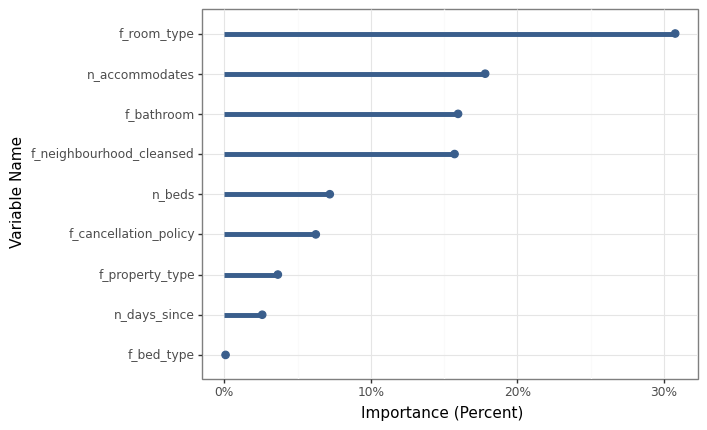

<ggplot: (388647063)>

In [32]:
(
    ggplot(
        grouped_imp,
        aes(x="reorder(varname, imp)", y="imp_percentage"),
    )
    + geom_point(color=color[0], size=2.5)
    + geom_segment(
        aes(x="varname", xend="varname", y=0, yend="imp_percentage"),
        color=color[0],
        size=2,
    )
    + ylab("Importance (Percent)")
    + xlab("Variable Name")
    + coord_flip()
    + scale_y_continuous(labels=percent_format())
    + theme_bw()
)


## Partial Dependence Plots 
-------------------------------------------------------


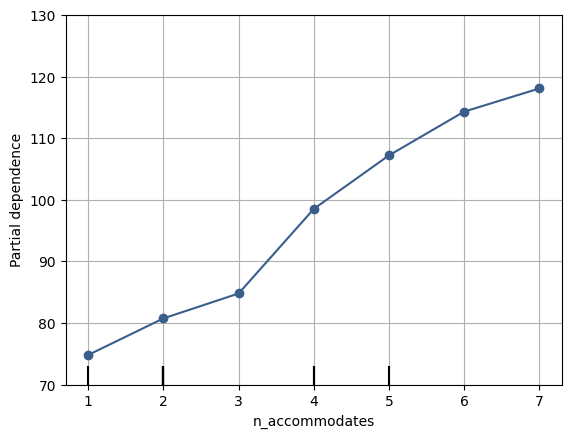

In [33]:
# Note: easy way, sklearn has plot_partial_dependence function
# we do this on holdout set!
plot_partial_dependence(
    rf_best_pipeline,
    data_holdout[predictors_2],
    ["n_accommodates"],
    feature_names=data_holdout[predictors_2].columns,
    line_kw={"marker": "o", "color": color[0]},
)
plt.grid()
plt.ylim(70, 130)
plt.show()


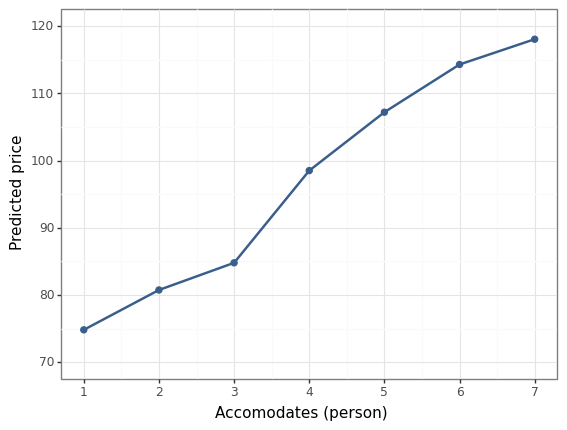

<ggplot: (678868240)>

In [34]:
# replicate the exact book figure with plotnine
accom_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

accom_pdp = (
    pd.DataFrame(accom_pdp["average"], columns=accom_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Accomodates (person)"}, axis=1)
)

(
    ggplot(accom_pdp, aes(x="Accomodates (person)", y="Predicted price"))
    + geom_point(color=color[0], size=2)
    + geom_line(color=color[0], size=1)
    + scale_y_continuous(limits=[70, 120], breaks=seq(70, 121, 10))
    + scale_x_continuous(breaks=range(1, 8))
    + theme_bw()
)


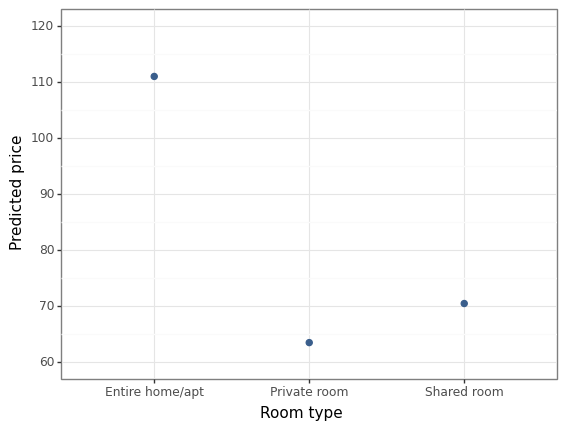

<ggplot: (678907016)>

In [35]:
roomtype_pdp = partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

roomtype_pdp = (
    pd.DataFrame(roomtype_pdp["average"], columns=roomtype_pdp["values"][0].tolist())
    .T.reset_index()
    .rename({0: "Predicted price", "index": "Room type"}, axis=1)
)

(
    ggplot(roomtype_pdp, aes(x="Room type", y="Predicted price"))
    + geom_point(color=color[0], size=2)
    + scale_y_continuous(limits=[60, 120], breaks=seq(60, 121, 10))
    + theme_bw()
)


### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [36]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_best_pipeline.predict(data_holdout[predictors_2])
)


create nice summary table of heterogeneity

In [37]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )


In [38]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)


In [39]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)


In [40]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)


In [41]:
all_holdout = (
    pd.DataFrame(
        [
            mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
                squared=False,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]


In [42]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")


### Table 16.2 Performance across subsamples

In [43]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)


,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,65.25,144.06,0.45
small apt,30.98,62.86,0.49
Type,,,
Apartment,43.23,93.19,0.46
House,50.06,77.49,0.65
Borough,,,
Camden,52.52,105.01,0.5
Hackney,38.75,76.05,0.51
Kensington and Chelsea,65.96,143.55,0.46


## SHAP

In [44]:
import shap

SHAP Explainer takes an encoded matrix as input

In [46]:
rf_best_pipeline["preprocess"].fit(data_holdout.filter(predictors_2))

# transform categorical features
X_encoded = rf_best_pipeline["preprocess"].transform(data_holdout.filter(predictors_2))
new_feature_names = [
    i.replace("cat__", "").replace("num__", "")
    for i in rf_best_pipeline["preprocess"].get_feature_names_out()
]
X_holdout = pd.DataFrame(X_encoded, columns=new_feature_names)

Calculate SHAP values for our best model

**NOTE:** Again, we do this on the holdout set!

In [50]:
explainer = shap.Explainer(rf_best_pipeline["regressor"].predict, X_holdout)
shap_values = explainer(X_holdout)

Permutation explainer: 14949it [06:43, 36.10it/s]                                                                                                       


### Beeswarm plot of SHAP values

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature row. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature. In the plot below we can see that Entire home/apt is the most important feature on average, and than Entire home/apt-s are more expensive.



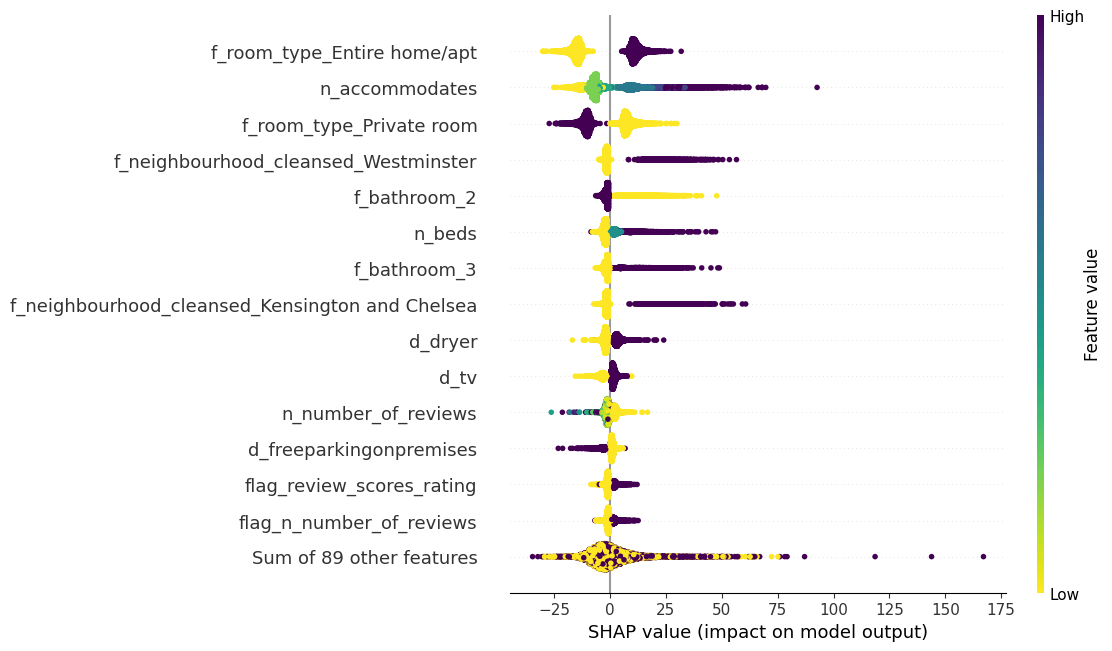

In [52]:
shap.plots.beeswarm(shap_values, max_display = 15, color=plt.get_cmap("viridis_r"),show=True)

Can do the same with **SHAP values scaled log**. This might come handy, when the distribution of SHAP values are skewed

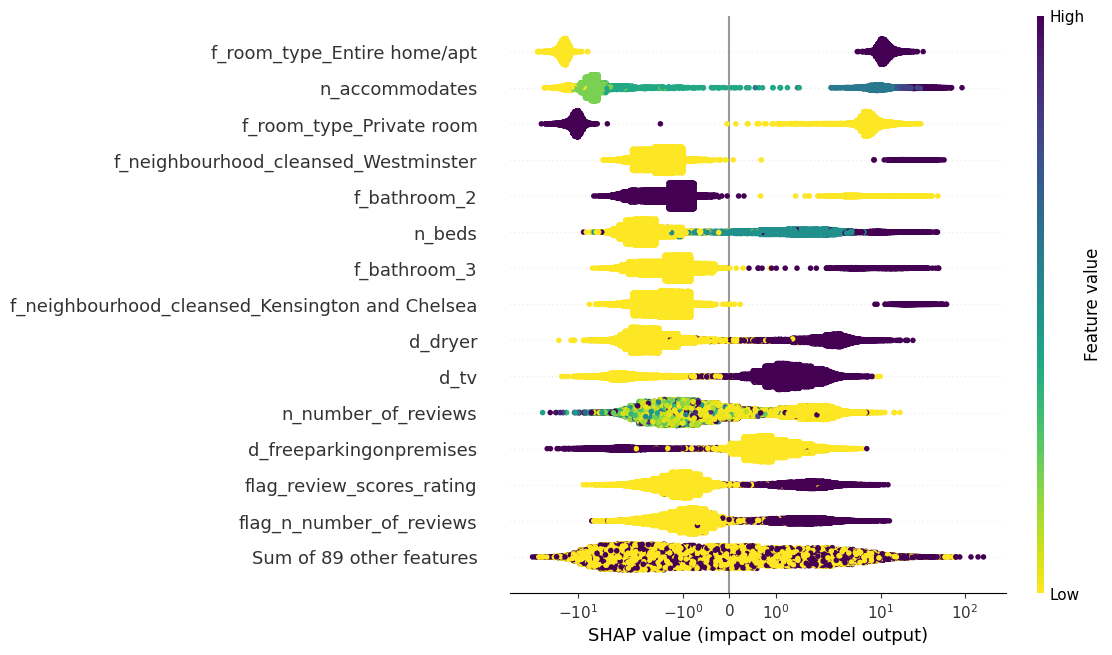

In [53]:
shap.plots.beeswarm(
    shap_values, max_display=15, log_scale=True, color=plt.get_cmap("viridis_r")
)

You can also display the **SHAP values in absolute**, on a beeswarm plot

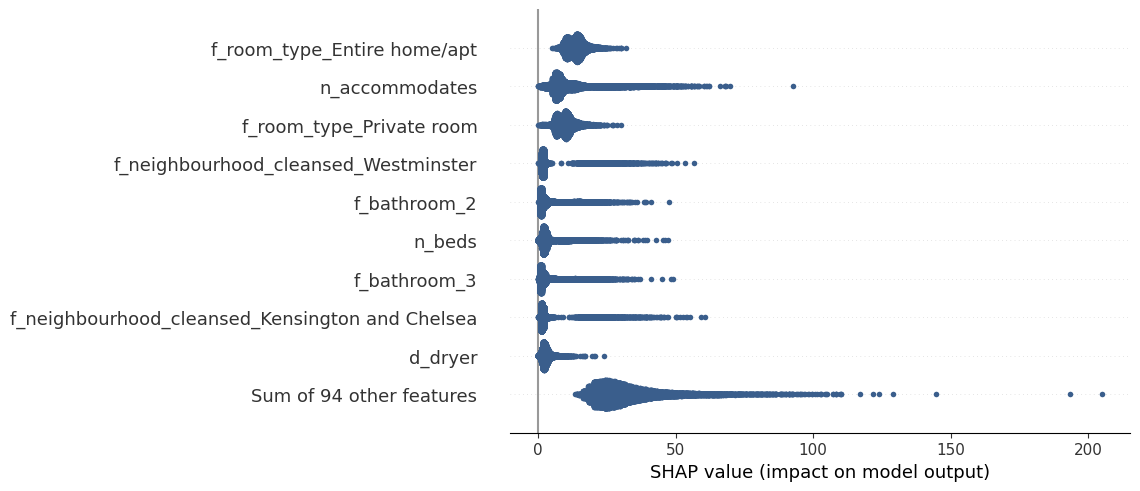

In [54]:
shap.plots.beeswarm(shap_values.abs, color=color[0])

Or on a barplot

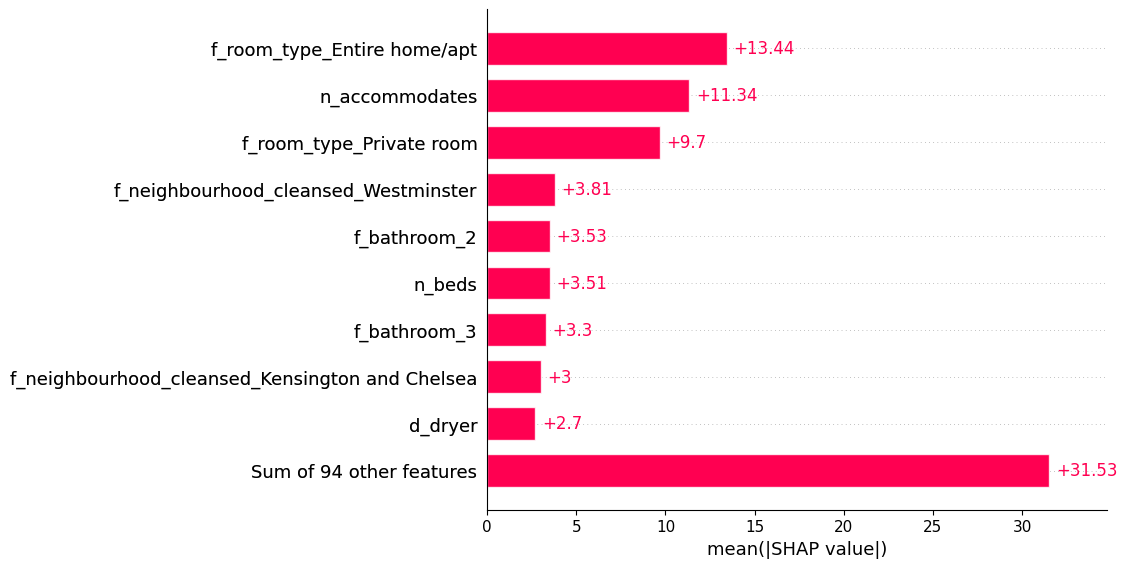

In [55]:
shap.plots.bar(shap_values)

### Explanining predictions for a unit of observation (airbnb)

Let's look at SHAP values for the third observation in the holdout set. 

- .values array contains the shap values
- .base_values contains the expected value (intercept/constant in OLS terms)
- .data contains the feature values for the observation

In [56]:
shap_values[2]

.values =
array([ 2.68929052e-01,  1.65928000e-01,  9.03200054e+00,  7.15933486e+00,
        0.00000000e+00,  0.00000000e+00, -2.12293958e+00, -2.60420445e+00,
        6.31840216e-01, -1.28421106e+00, -1.79358191e+00, -4.36230159e-03,
        9.61688612e-03,  0.00000000e+00,  3.04088624e-02,  0.00000000e+00,
        4.95970569e-02,  0.00000000e+00, -3.09955706e-01,  0.00000000e+00,
        0.00000000e+00,  5.18908730e-03,  0.00000000e+00,  1.08303571e-02,
       -4.03794763e-02, -3.38269180e-02,  8.11490049e-02,  4.14935847e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.43989628e-02,
       -1.04277824e+00,  2.66666667e-03, -2.66580362e-02,  5.62741416e-02,
       -2.57268939e-02,  6.41521164e-03,  0.00000000e+00,  1.77919312e-02,
       -7.92509019e-03,  4.68750000e-03,  1.22809554e-02,  1.51784722e-02,
       -3.27031339e-02,  1.60424616e+01, -7.74435789e+00, -1.96564054e+00,
       -6.32035431e-01, -1.91542645e+00, -1.41054770e+00, -1.73323034e+00,
       -1.00154

#### Waterfall plot
The waterfall plot shows how the sum of all the SHAP values equals the difference between the prediction $f(x)$ and the expected value $E[f(x)]$. Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

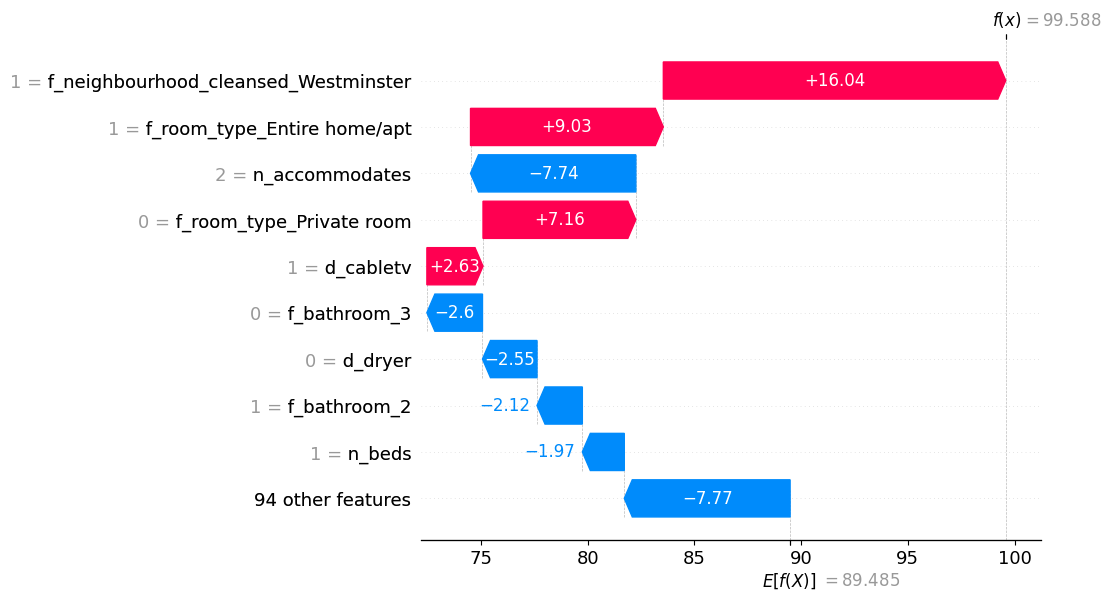

In [57]:
shap.plots.waterfall(shap_values[2])

Same plot, but SHAP values for another observation below.

Note, that for a same predictor (eg. f_room_type_Private room = 0) the SHAP values are different for the airbnb above (+5.29) and above (+6.88).

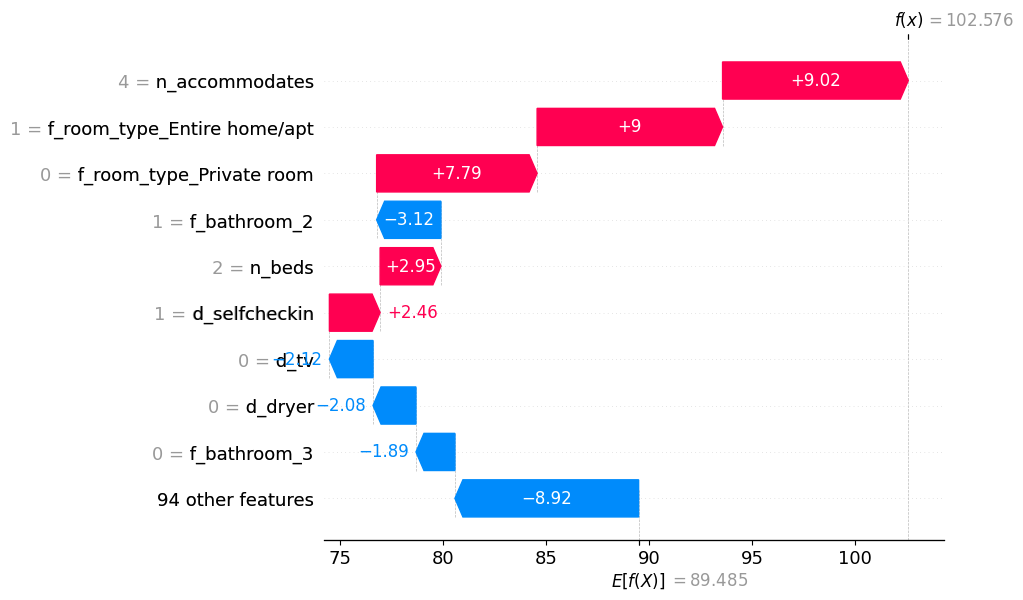

In [58]:
shap.plots.waterfall(shap_values[3])

## Interactions

Look at interactions from `ch14-airbnb-reg`

In [54]:
(
    "f_room_type*d_familykidfriendly",
    "f_room_type*f_property_type",
    "f_property_type*d_airconditioning",
    "f_property_type*d_cats",
    "f_property_type*d_dogs",
)

('f_room_type*d_familykidfriendly',
 'f_room_type*f_property_type',
 'f_property_type*d_airconditioning',
 'f_property_type*d_cats',
 'f_property_type*d_dogs')

To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument **the scatter plot will pick the best feature to color by.**

Get best proposed interaction by SHAP values for room types. Note that the grey area on the plot corresponds to the distribution of the feature in the data.

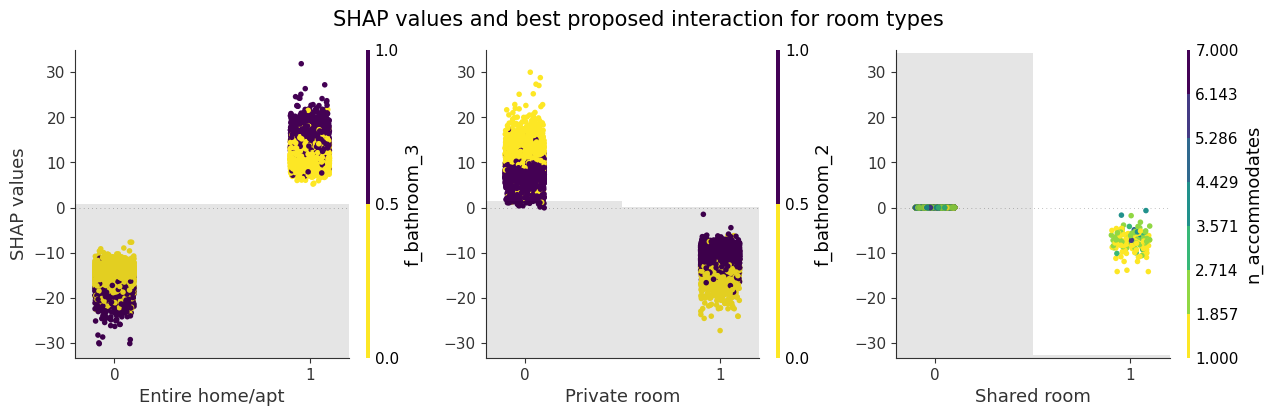

In [59]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for room types",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "f_room_type_Entire home/apt"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlabel("Entire home/apt")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "f_room_type_Private room"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlabel("Private room")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "f_room_type_Shared room"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlabel("Shared room")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

It turned out, that for the `f_room_type` variable the best interaction (at least based on RF and SHAP) would be the `f_bathroom` which we did not choose in ch14.

Let's check for `d_airconditioning`, `d_dogs` and `d_cats`.

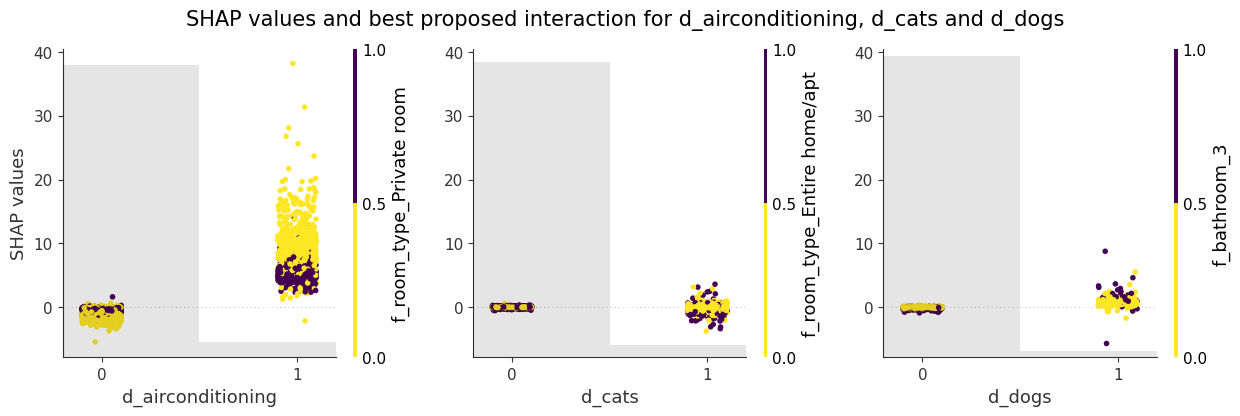

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for d_airconditioning, d_cats and d_dogs",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "d_airconditioning"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_cats"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_dogs"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

The distribution in grey is switched off

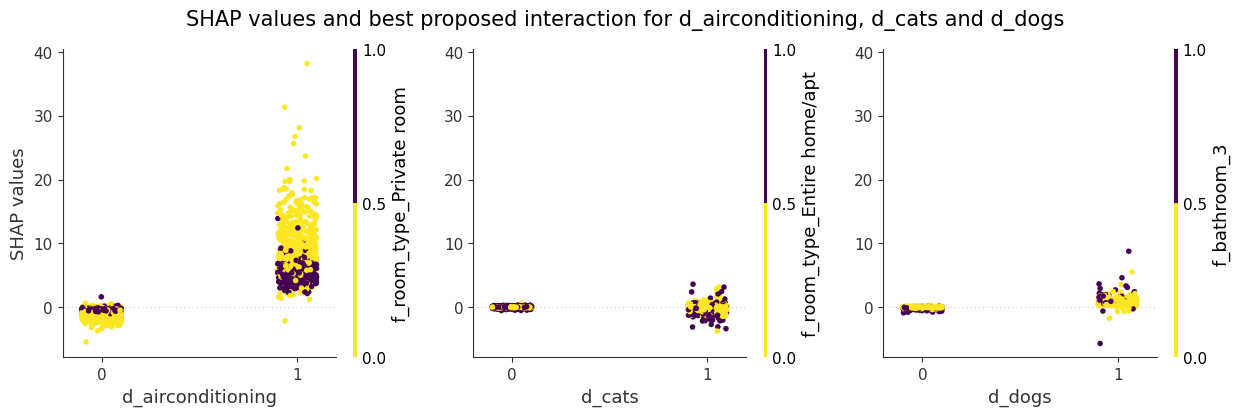

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for d_airconditioning, d_cats and d_dogs",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "d_airconditioning"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_cats"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_dogs"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

Take a look at a discrete feature, `n_accommodates`

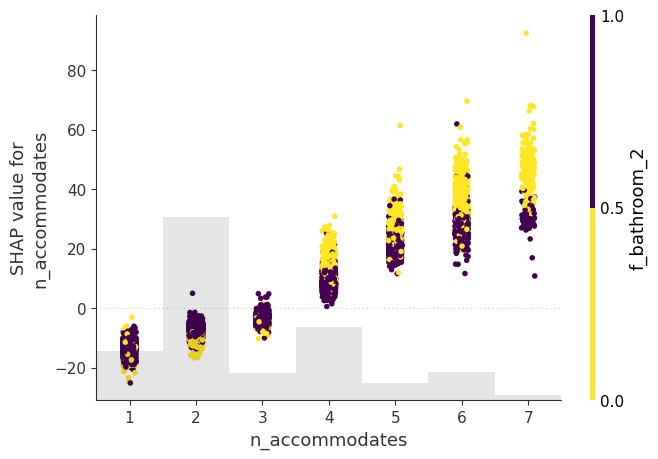

In [67]:
shap.plots.scatter(
    shap_values[:, "n_accommodates"], color=shap_values, cmap=plt.get_cmap("viridis_r")
)

## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------
**NOTE: this part of the code is not finished**

1. OLS with dummies for area

 using model B

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


In [56]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X, y)

# y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y, y_hat, squared=False)
ols_rmse


47.15367981281546

In [57]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))


In [58]:
ols_model_coeffs_df


,ols_coefficient
Intercept,-0.000
f_property_type[T.House],7.384
f_room_type[T.Private room],-34.916
f_room_type[T.Shared room],-44.568
f_cancellation_policy[T.moderate],-1.296
...,...
d_tv,6.066
d_washer,-4.694
d_washerdryer,80.073
d_wheelchairaccessible,-1.931


2.  LASSO

using extended model w interactions

In [59]:
from sklearn.linear_model import ElasticNet


The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [60]:
lasso_model = ElasticNet(l1_ratio=1, normalize=True, fit_intercept=True)


In [61]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [62]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)


In [63]:
lasso_model_cv.fit(X, y.ravel())


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ......................alpha=0.01;, score=-48.060 total time=   0.5s
[CV 2/5] END ......................alpha=0.01;, score=-46.621 total time=   0.6s
[CV 3/5] END ......................alpha=0.01;, score=-47.374 total time=   0.6s
[CV 4/5] END ......................alpha=0.01;, score=-45.666 total time=   0.5s
[CV 5/5] END ......................alpha=0.01;, score=-48.527 total time=   0.6s
[CV 1/5] END ......................alpha=0.02;, score=-49.666 total time=   0.4s
[CV 2/5] END ......................alpha=0.02;, score=-48.011 total time=   0.4s
[CV 3/5] END ......................alpha=0.02;, score=-48.783 total time=   0.4s
[CV 4/5] END ......................alpha=0.02;, score=-47.267 total time=   0.5s
[CV 5/5] END ......................alpha=0.02;, score=-50.198 total time=   0.4s
[CV 1/5] END ......................alpha=0.03;, score=-50.921 total time=   0.3s
[CV 2/5] END ......................alpha=0.03;,

[CV 2/5] END ......................alpha=0.21;, score=-63.643 total time=   0.1s
[CV 3/5] END ......................alpha=0.21;, score=-66.111 total time=   0.1s
[CV 4/5] END ......................alpha=0.21;, score=-64.880 total time=   0.1s
[CV 5/5] END ......................alpha=0.21;, score=-67.910 total time=   0.1s
[CV 1/5] END ......................alpha=0.22;, score=-67.441 total time=   0.1s
[CV 2/5] END ......................alpha=0.22;, score=-64.509 total time=   0.1s
[CV 3/5] END ......................alpha=0.22;, score=-67.022 total time=   0.1s
[CV 4/5] END ......................alpha=0.22;, score=-65.796 total time=   0.1s
[CV 5/5] END ......................alpha=0.22;, score=-68.842 total time=   0.2s
[CV 1/5] END ......................alpha=0.23;, score=-68.368 total time=   0.1s
[CV 2/5] END ......................alpha=0.23;, score=-65.407 total time=   0.1s
[CV 3/5] END ......................alpha=0.23;, score=-67.963 total time=   0.1s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1, normalize=True),
             param_grid={'alpha': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
                                   0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14,
                                   0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21,
                                   0.22, 0.23, 0.24, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [64]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]


,lasso_coefficient
f_room_type[T.Private room],-34.621
f_room_type[T.Shared room],-28.398
f_cancellation_policy[T.strict],1.787
f_neighbourhood_cleansed[T.City of London],12.601
f_room_type[T.Private room]:f_property_type[T.House],-4.161
f_property_type[T.House]:f_neighbourhood_cleansed[T.Kensington and Chelsea],34.572
n_accommodates,11.893
n_accommodates:f_property_type[T.House],2.031
n_accommodates:f_neighbourhood_cleansed[T.Camden],3.890
n_accommodates:f_neighbourhood_cleansed[T.City of London],1.551


In [65]:
lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
lasso_rmse


47.24976190971253

3. CART model

In [66]:
from sklearn.tree import DecisionTreeClassifier


In [67]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)


In [68]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")


In [69]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [70]:
# apply random search to select a "best" alpha
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X, y.ravel())


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .ccp_alpha=3.583921096393142e-05;, score=-61.543 total time=   0.9s
[CV 2/5] END .ccp_alpha=3.583921096393142e-05;, score=-61.428 total time=   0.8s
[CV 3/5] END .ccp_alpha=3.583921096393142e-05;, score=-63.502 total time=   0.8s
[CV 4/5] END .ccp_alpha=3.583921096393142e-05;, score=-59.553 total time=   1.2s
[CV 5/5] END .ccp_alpha=3.583921096393142e-05;, score=-61.131 total time=   1.2s
[CV 1/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.582 total time=   0.8s
[CV 2/5] END ccp_alpha=2.8671368771145135e-05;, score=-61.532 total time=   0.9s
[CV 3/5] END ccp_alpha=2.8671368771145135e-05;, score=-63.607 total time=   0.8s
[CV 4/5] END ccp_alpha=2.8671368771145135e-05;, score=-65.984 total time=   0.8s
[CV 5/5] END ccp_alpha=2.8671368771145135e-05;, score=-62.293 total time=   1.0s
[CV 1/5] END .ccp_alpha=4.013991627960319e-05;, score=-58.368 total time=   1.6s
[CV 2/5] END .ccp_alpha=4.013991627960319e-05;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2018),
                   param_distributions={'ccp_alpha': array([0.00000000e+00, 2.40598899e-06, 2.86713688e-06, ...,
       9.49341420e-04, 1.09022941e-03, 1.00707174e-02])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [71]:
cart_rmse = (
    pd.DataFrame(cart_model_cv.cv_results_)
    .loc[lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha]
    .mean_test_score.values[0]
    * -1
)
cart_rmse


59.98927856677494

4. GBM

**NOTE:** These models run for a **very long time** -- needs further investigations.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)


In [ ]:
gbm_pipe.fit(data_train[predictors_2], data_train.price)


the next will be in final model, loads of tuning

In [ ]:
gbm_broad = GradientBoostingRegressor()


In [ ]:
tune_grid = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)


In [ ]:
gbm_pipe_broad.fit(data_train[predictors_2], data_train.price)
